### Hypothesis Testing with Men's and Women's Soccer Matches
_Data Analysis in Python_

---

#### Introduction

Completing this program equipped me with a range of valuable skills:

1. **Statistical Analysis**: I gained proficiency in conducting statistical analyses, including hypothesis  
testing, using Python libraries such as Pingouin and SciPy.

2. **Data Preparation**: I learned how to efficiently filter and preprocess datasets, ensuring data is  
relevant for analysis.

3. **Data Visualization**: Through creating histograms and visualizing data distributions, I honed my skills  
in data visualization, enabling me to communicate insights effectively.

4. **Hypothesis Testing**: I deepened my understanding of hypothesis testing methodologies, particularly the  <br>Wilcoxon-Mann-Whitney test, and how to interpret results in the context of different significance levels.

5. **Python Programming**: This project further solidified my Python programming skills, particularly in data <br>manipulation, analysis, and utilizing external libraries for statistical computations.

6. **Critical Thinking and Problem-Solving**: Analyzing the research question and selecting appropriate  
statistical methods required critical thinking and problem-solving skills, enhancing my ability to approach  
complex problems systematically.

Overall, this project provided a comprehensive learning experience in statistical analysis and data-driven  <br>decision-making within the domain of sports journalism and analytics.

#### Project Brief

As a sports journalist your gut instinct tells you that more goals are scored in women's international football  
matches than men's. Perform a valid statistical hypothesis test to be sure!

Limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since  
`2002-01-01` and assume that each match is fully independent, i.e., team form is ignored.

Two datasets containing the results of every official men's and women's international football match since the  
19th century, are stored in two CSV files: `women_results.csv` and `men_results.csv`

#### Objective

Determine the answer to the question:

> Are more goals scored in women's international soccer matches than men's?

Assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_{0}$: The mean number of goals scored in women's international soccer matches is the same as men's.

$H_{A}$: The mean number of goals scored in women's international soccer matches is greater than men's.

Perform an appropriate hypothesis test to determine the p-value, and hence the result, of whether to reject  
or fail to reject the null hypothesis. 

Store the p-value and the result of the test in a dictionary called `result_dict` in the form:

`result_dict = {'p_val': p_val, 'result': result}`

where `result` is either the string `'fail_to_reject'` or `'reject'`, depending on the result  
of the test.

#### Start of Analysis

In [2]:
# Load required libraries
import pandas as pd
import matplotlib.pyplot as plt
import pingouin
from scipy.stats import mannwhitneyu

##### 1. Exploratory data analysis

In [3]:
# Load the men's and women's datasets
men = pd.read_csv('data/men_results.csv', index_col=0)
women = pd.read_csv('data/women_results.csv', index_col=0)

In [4]:
# Check column names & data types
print(men.info())

<class 'pandas.core.frame.DataFrame'>
Index: 44353 entries, 0 to 44352
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        44353 non-null  object
 1   home_team   44353 non-null  object
 2   away_team   44353 non-null  object
 3   home_score  44353 non-null  int64 
 4   away_score  44353 non-null  int64 
 5   tournament  44353 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB
None


In [5]:
# Check column names & data types
print(women.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4884 entries, 0 to 4883
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        4884 non-null   object
 1   home_team   4884 non-null   object
 2   away_team   4884 non-null   object
 3   home_score  4884 non-null   int64 
 4   away_score  4884 non-null   int64 
 5   tournament  4884 non-null   object
dtypes: int64(2), object(4)
memory usage: 267.1+ KB
None


##### 2. Filter the data

In [6]:
# Filter the data for the time range and tournament
men['date'] = pd.to_datetime(men['date'])
men_subset = men[(men['date'] > '2002-01-01') & (men['tournament'].isin(['FIFA World Cup']))]

women['date'] = pd.to_datetime(women['date'])
women_subset = women[(women['date'] > '2002-01-01') & (women['tournament'].isin(['FIFA World Cup']))]

In [16]:
# Create group and goals_scored columns
men_subset.loc[:, 'group'] = 'men'
women_subset.loc[:, 'group'] = 'women'

men_subset.loc[:, 'goals_scored'] = men['home_score'] + men['away_score']
women_subset.loc[:, 'goals_scored'] = women['home_score'] + women['away_score']

##### 3. Choosing the correct hypothesis test

* Because there are two independent groups, men's and women's, this scenario requires an _unpaired_ two-sample  
test.

* An unpaired t-test and a non-parametric version of the unpaired t-test, the Wilcoxon-Mann-Whitney test, are  
the two most common two-sample tests.

* To determine if a parametric or non-parametric test is appropriate, verify the underlying assumptions of  
parametric tests, including checking the sample size in each group and the normality of each distribution.

##### Determining if the data is normally distributed

* The normal distribution is a symmetric bell-shaped curve, with the distribution centered around the mean.

* Plot a histogram displaying the distribution of the number of goals scored in men's and women's matches to   
check whether the data is normally distributed or not.

* If the normality is unclear from the plot, run a test of normality, such as a Kolmogorov-Smirnov test or  
the Shapiro-Wilk test.

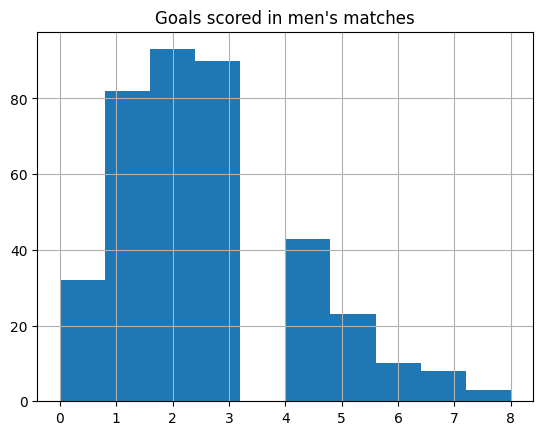

In [17]:
# Determine normality using a histogram
men_subset['goals_scored'].hist()
plt.title("Goals scored in men's matches")
plt.show()

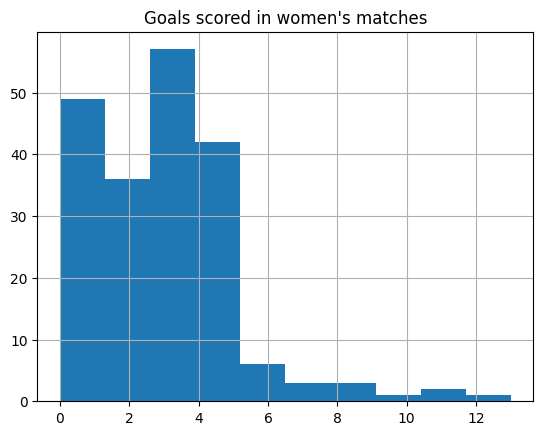

In [18]:
# Determine normality using a histogram
women_subset['goals_scored'].hist()
plt.title("Goals scored in women's matches")
plt.show()

##### 4. Performing the hypothesis test

The Wilcoxon-Mann-Whitney test is the most appropriate in this scenario as the data is not normally distributed.

In [19]:
# Combine women's and men's data
both = pd.concat([women_subset, men_subset], axis=0, ignore_index=True)
print(both.head())

        date      home_team    away_team  home_score  away_score  \
0 2003-09-20        Nigeria  North Korea           0           3   
1 2003-09-20         Norway       France           2           0   
2 2003-09-20        Germany       Canada           4           1   
3 2003-09-20          Japan    Argentina           6           0   
4 2003-09-21  United States       Sweden           3           1   

       tournament  group  goals_scored  
0  FIFA World Cup  women             3  
1  FIFA World Cup  women             2  
2  FIFA World Cup  women             5  
3  FIFA World Cup  women             6  
4  FIFA World Cup  women             4  


In [20]:
# Transform the data for the Wilcoxon-Mann-Whitney test
both_subset = both[['group', 'goals_scored']]
# Pivot the DataFrame to wide-format as required by the test
both_subset_wide = both_subset.pivot(columns='group', values='goals_scored')

> Hypothesis test using pingouin

`pingouin.mwu()` can be used to perform a Wilcoxon-Mann-Whitney test. It takes three arguments:  

* `x`, the values from the pivoted table which are suspected to be higher from the hypothesis,
* `y`, the values to compare against,
* `alternative`, an argument indicating whether the test is left-tailed, right-tailed, or two-tailed

In [21]:
# Run a right-tailed test with pingouin
results_pg = pingouin.mwu(
    x=both_subset_wide['women'],
    y=both_subset_wide['men'],
    alternative='greater'
)
print(results_pg)

       U-val alternative     p-val       RBC      CLES
MWU  43273.0     greater  0.005107 -0.126901  0.563451


> Hypothesis test using SciPy (alternative method)

`scipy.stats.mannwhitneyu()` can be used to perform a Wilcoxon-Mann-Whitney test.  
It takes three arguments:

* `x`, the values suspected to be higher from the hypothesis,
* `y`, the values to compare against,
* `alternative`, an argument indicating whether the test is left-tailed, right-tailed, or two-tailed


In [22]:
# Run a right-tailed test with SciPy
results_scipy = mannwhitneyu(
    women_subset['goals_scored'],
    men_subset['goals_scored'],
    alternative='greater'
)
print(results_scipy)

MannwhitneyuResult(statistic=43273.0, pvalue=0.005106609825443641)


In [23]:
# Extract p-value from pingouin test result
p_val = results_pg['p-val'].values[0]
print(p_val)

0.005106609825443641


##### 5. Interpreting the result of the hypothesis test

* If $p-value \le 0.1 $, reject the null hypothesis, otherwise, fail to reject it.

In [24]:
# Determine hypothesis test result
if p_val <= 0.1:
    result = 'reject'
else:
    result = 'fail to reject'

result_dict = {'p_val': p_val, 'result': result}
print(result_dict)

{'p_val': 0.005106609825443641, 'result': 'reject'}


##### Conclusion

The result of the hypothesis test shows the mean number of goals scored in women's international soccer  
matches is greater than men's.